# V3は手動でデータの組み合わせを変更し、自動で入力系列数と出力次元数を変更するプログラムです

## ライブラリをインポート

In [1]:
from keras.models import Sequential
from keras.utils import np_utils, plot_model
from keras.layers import Dense, Activation, Dropout, LSTM
from keras.initializers import glorot_uniform, orthogonal, TruncatedNormal
from keras.callbacks import EarlyStopping
from keras.layers.recurrent import GRU, SimpleRNN

import pandas as pd #行列計算
import numpy as np #行列計算
import math #数値計算
import itertools #順列・組み合わせ
import time
import talib as ta # テクニカル指標

import matplotlib.pyplot as plt #グラフ
import winsound # ビープ音
import os

from df_method import rise_fall_rate, moving_average, GCDC, df_shift, add_data, RSI, Z_score_normalization, Min_Max_normalization

Using TensorFlow backend.


## ニューラルネットワーク構築

In [2]:
class Prediction :
    #初期化
    def __init__(self, maxlen, n_hidden, n_in, n_out, learning_model):
        self.maxlen = maxlen #入力系列数
        self.n_hidden = n_hidden #出力次元（隠れ層内のニューロン数）
        self.n_in = n_in #学習データの列数
        self.n_out = n_out #ラベルデータの列数
        
        self.learning_model = learning_model #●学習モデルの選択

    #モデルの生成
    def create_model(self):
        model = Sequential()
        if self.learning_model == 'RNN':
            #RNN層
            model.add(SimpleRNN(self.n_hidden,
                                batch_input_shape = (None, self.maxlen, self.n_in),
                                kernel_initializer = glorot_uniform(seed=20170719),
                                recurrent_initializer = orthogonal(gain=1.0, seed=20170719),
                                dropout = 0.5,
                                recurrent_dropout = 0.5))
        elif self.learning_model == 'LSTM':
            #LSTM層
            model.add(LSTM(self.n_hidden,
                           batch_input_shape = (None, self.maxlen, self.n_in),
                           kernel_initializer = glorot_uniform(seed=20170719), 
                           recurrent_initializer = orthogonal(gain=1.0, seed=20170719), 
                           dropout = 0.5, 
                           recurrent_dropout = 0.5))
        elif self.learning_model == 'GRU':
            #GRU層
            model.add(GRU(self.n_hidden,
                          batch_input_shape = (None, self.maxlen, self.n_in),
                          kernel_initializer = glorot_uniform(seed=20170719),
                          recurrent_initializer = orthogonal(gain=1.0, seed=20170719),
                          dropout = 0.5,
                          recurrent_dropout = 0.5))
        #ドロップアウト層
        model.add(Dropout(0.5))
        #結合層
        model.add(Dense(self.n_out, kernel_initializer = glorot_uniform(seed=20170719)))
        #活性化層
        model.add(Activation("softmax"))
        #コンパイル
        model.compile(loss="categorical_crossentropy", optimizer = "Adam", metrics = ['categorical_accuracy']) # "RMSprop"
        return model

    # 学習
    def train(self, x_train, t_train, batch_size, epochs) :
        early_stopping = EarlyStopping(patience=0, verbose=1)
        model = self.create_model()
        self.hist = model.fit(x_train, t_train, batch_size = batch_size, epochs = epochs, verbose = 1,
                              shuffle = True, callbacks = [early_stopping], validation_split = 0.1)
        return model

## 変数宣言

In [3]:
is_debug = True
csv_path = './csv_realtime/'
x_days_later = 1 # '1', '2', '7', '30', '365'
learning_model = 'GRU' #['RNN', 'LSTM', 'GRU']
start_date = '2009-3-10' #  '1960', '1970', '1980', '1990', '2000', '2010'
end_date = '2018-10-31'# 終点年月日

min_maxlen = 300#100
max_maxlen = 300#1000
min_n_hidden = 200#100
max_n_hidden = 200#500

target_name = 'USD_JPY_diff'# 'nikkei_Close', 'nikkei_diff', 'USD_JPY'
max_score = 0 # 最高正答率

## 学習データの用意

In [4]:
df_list = {} # データフレームの辞書
df_list_name = ''

#ドル円の始値と終値の差
df = pd.read_csv(csv_path+'USD_JPY.csv', index_col='Date', parse_dates=True)#読み込み
df = df.apply(np.log)*100#正規化
df = df['USD_JPY_Close'] - df['USD_JPY_Open']#終値と始値の差を求める
df = df['1989-10-16':]#始値と終値と高値と安値が記録され始めた日からのみ抽出
df = df.rename('USD_JPY_diff')#名前を付ける
df = pd.DataFrame(df)# sriesからdataframeに変換
df_list['USD_JPY_diff'] = df

# 為替レート
df_list['USD_JPY'] = add_data(csv_path+'USD_JPY.csv', x_days_later)
#df_list['EUR_JPY'] = add_data(csv_path+'EUR_JPY.csv', x_days_later)
#df_list['EUR_USD'] = add_data(csv_path+'EUR_USD.csv', x_days_later)

# 株価指数
#df_list['nikkei'] = add_data(csv_path+'nikkei.csv', x_days_later)
#df_list['TOPIX'] = add_data(csv_path+'TOPIX.csv', x_days_later)
#df_list['DOW30'] = add_data(csv_path+'DOW30.csv', x_days_later)
#df_list['NASDAQ'] = add_data(csv_path+'NASDAQ.csv', x_days_later)

# 米国債
df = pd.read_csv(csv_path+'treasury_10.csv', index_col='Date', parse_dates=True)
df_list['treasury_10'] = rise_fall_rate(df, x_days_later)

# テクニカル指標を求めるために使用-----------------------------------------
df = pd.read_csv(csv_path+'USD_JPY.csv', index_col=0, parse_dates=True)
df_close = df['USD_JPY_Close']

In [5]:
# 指数移動平均----------------------------------------------------

sma5 = ta.SMA(df_close, timeperiod=5)
sma25 = ta.SMA(df_close, timeperiod=25)
sma75 = ta.SMA(df_close, timeperiod=75)
sma5.name = 'sma5'
sma25.name = 'sma25'
sma75.name = 'sma75'
SMA = pd.DataFrame(sma5)
SMA = SMA.join(sma25)
SMA = SMA.join(sma75)
SMA = SMA.dropna()
#df_list.append(SMA)

#one-hotベクトル
"""
SMA_diff = sma5 - sma25
SMA_diff = SMA_diff.dropna()
# 空のデータフレーム作成
SMA_one_hot = pd.DataFrame(index=SMA_diff.index, columns=['positive', 'negative'])
SMA_one_hot = SMA_one_hot.fillna(0) #０で埋める
# 条件にあった値を置換する
SMA_one_hot.loc[0 <= SMA_diff, 'positive'] = 1
SMA_one_hot.loc[SMA_diff < 0, 'negative'] = 1
df_list['SMA_5_25_one_hot'] = SMA_one_hot
"""

# 5日移動平均
"""
target = df_close[SMA.index[0]:]
df = SMA['sma5'] - target
df.name = 'sma5'
df_list['SMA_5'] = df
"""

SMA_diff = sma5 - sma25
SMA_diff = SMA_diff.dropna()
SMA_diff.name = 'SMA_5_25'
#rint(SMA_diff)
df_list['SMA_5_25'] = SMA_diff


In [5]:
# ★ボリンジャーバンド

upper1, middle1, lower1 = ta.BBANDS(df_close, timeperiod=5, nbdevup=1, nbdevdn=1)
upper2, middle2, lower2 = ta.BBANDS(df_close, timeperiod=5, nbdevup=2, nbdevdn=2)
upper3, middle3, lower3 = ta.BBANDS(df_close, timeperiod=5, nbdevup=3, nbdevdn=3)
upper3.name = 'upper3'
upper2.name = 'upper2'
upper1.name = 'upper1'
middle1.name = 'middle'
lower1.name = 'lower1'
lower2.name = 'lower2'
lower3.name = 'lower3'
BB = pd.DataFrame(upper3)
BB = BB.join(upper2)
BB = BB.join(upper1)
BB = BB.join(middle1)
BB = BB.join(lower1)
BB = BB.join(lower2)
BB = BB.join(lower3)
BB = BB.dropna()
#df_list['BB'] = BB # そのまま入れる

# ラベルデータを作成する列
target = df_close[BB.index[0]:]
# 空のデータフレーム作成
#df_t = pd.DataFrame(index=BB.index, columns=['over3', 'over2', 'over1', 'over0', 'less0', 'less1', 'less2', 'less3'])
df_t = pd.DataFrame(index=BB.index, columns=['over3', 'over2', 'over1', 'neutral', 'less1', 'less2', 'less3'])
df_t = df_t.fillna(0) #０で埋める
# 条件にあった値を置換する
df_t.loc[BB["upper3"] <= target, 'over3'] = 1
df_t.loc[(BB["upper2"] <= target) & (target < BB["upper3"]), 'over2'] = 1
df_t.loc[(BB["upper1"] <= target) & (target < BB["upper2"]), 'over1'] = 1
#df_t.loc[(BB["middle"] <= target) & (target < BB["upper1"]), 'over0'] = 1
#df_t.loc[(BB["lower1"] <= target) & (target < BB["middle"]), 'less0'] = 1
df_t.loc[(BB["lower1"] <= target) & (target < BB["upper1"]), 'neutral'] = 1
df_t.loc[(BB["lower2"] <= target) & (target < BB["lower1"]), 'less1'] = 1
df_t.loc[(BB["lower3"] <= target) & (target < BB["lower2"]), 'less2'] = 1
df_t.loc[target < BB["lower3"], 'less3'] = 1
df_list['BB_one_hot_neutral'] = df_t

In [6]:
# ★RSI
RSI = ta.RSI(df_close, timeperiod=14)
RSI.name = 'RSI'
#df_list['RSI'] = RSI # そのまま入れる

# ラベルデータを作成する列
target = RSI#df_x[target_name]
# 空のデータフレーム作成
df_t = pd.DataFrame(index=RSI.index, columns=['over70', 'neutral', 'less30'])
df_t = df_t.fillna(0) #０で埋める
# 条件にあった値を置換する
df_t.loc[70 <= target, 'over70'] = 1
df_t.loc[(30 < target) & (target < 70), 'neutral'] = 1
df_t.loc[target <= 30, 'less30'] = 1
df_list['RSI_one_hot'] = df_t

"""# ●失敗
target = RSI#df_x[target_name]
df_t = pd.DataFrame(index=RSI.index, columns=['RSI'])
df_t = df_t.fillna(0) #０で埋める
df_t.loc[70 <= target, 'RSI'] = 2
df_t.loc[(30 < target) & (target < 70), 'RSI'] = 1
df_list['RSI2'] = df_t
"""

"# ●失敗\ntarget = RSI#df_x[target_name]\ndf_t = pd.DataFrame(index=RSI.index, columns=['RSI'])\ndf_t = df_t.fillna(0) #０で埋める\ndf_t.loc[70 <= target, 'RSI'] = 2\ndf_t.loc[(30 < target) & (target < 70), 'RSI'] = 1\ndf_list['RSI2'] = df_t\n"

In [8]:
#ストキャスティクス
df = pd.read_csv(csv_path+'USD_JPY.csv', index_col=0, parse_dates=True)
df_close = df['USD_JPY_Close']
k, d = ta.STOCH(high=df['USD_JPY_High'], low=df['USD_JPY_Low'], close=df['USD_JPY_Close'])
k = k.dropna()
d = d.dropna()
#print(k)
#print(d)
STOCH_diff = k - d
target = STOCH_diff
# 空のデータフレーム作成
df_t = pd.DataFrame(index=STOCH_diff.index, columns=['positive', 'negative'])
df_t = df_t.fillna(0) #０で埋める
# 条件にあった値を置換する
df_t.loc[0 <= target, 'positive'] = 1
df_t.loc[target < 0, 'negative'] = 1
df_list['STOCH'] = df_t

## 全データフレームを結合

In [7]:
#全データフレームを結合
df_x = df_list[target_name] # 予測したいデータ
df_list_name = target_name # 予測したいデータの名前
for i, j in df_list.items(): #range(len(df_list) - 1):   
    if i == target_name:
        continue
    df_list_name = df_list_name + ' ' + i 
    df_x = df_x.join(j, how='inner', rsuffix='_' + i)

#指定の期間を抽出
if end_date == '':
    df_x = df_x[start_date:]
else:
    df_x = df_x[start_date:end_date]
    
print(df_x)

            USD_JPY_diff  USD_JPY_Open  USD_JPY_High  USD_JPY_Low  \
Date                                                                
2009-03-10     -0.182279      0.578359     -0.040339     0.010213   
2009-03-11     -1.418753     -0.172143     -0.303061    -0.882147   
2009-03-12      0.451283     -1.418753     -0.324281    -1.442457   
2009-03-13      0.326931      0.451283      0.131866     1.524847   
2009-03-16      0.091710      0.377918      0.000000     0.861014   
2009-03-17      0.416731      0.091710      0.323854     0.112205   
2009-03-18     -2.433260      0.416731     -0.131439    -2.477162   
2009-03-19     -1.792595     -2.402086     -2.282013    -2.261775   
2009-03-20      1.481042     -1.834914     -0.352551     0.649941   
2009-03-23      1.297843      1.251397      1.105326     1.580478   
2009-03-24      0.944469      1.308158      1.235403     1.318883   
2009-03-25     -0.378653      0.975117     -0.203149     0.010316   
2009-03-26      1.212754     -0.37

## ラベルデータの用意

In [8]:
# ラベルデータを作成する列
target = df_x[target_name]
#●デバッグ
            
# 空のデータフレーム作成
df_t = pd.DataFrame(index=df_x.index, columns=['jump', 'rise', 'fall', 'drop'])
df_t = df_t.fillna(0) #０で埋める

# 条件にあった値を置換する
df_t.loc[0.995033085 <= target, 'jump'] = 1
df_t.loc[(0 <= target) & (target < 0.995033085), 'rise'] = 1
df_t.loc[(-0.995033085 <= target) & (target < 0), 'fall'] = 1
df_t.loc[target < -0.995033085, 'drop'] = 1

# データを整える
df_t = df_t.shift(-1 * x_days_later, axis=0)#予測先日数分だけ縦にずらす
df_t = df_t.drop(df_t.index[-1*x_days_later:], axis=0)#ラベルデータ末尾の行を削除
df_x = df_x.drop(df_x.index[-1*x_days_later:], axis=0)#学習データの末尾の行を削除

print(df_t)

            jump  rise  fall  drop
Date                              
2009-03-10   0.0   0.0   0.0   1.0
2009-03-11   0.0   1.0   0.0   0.0
2009-03-12   0.0   1.0   0.0   0.0
2009-03-13   0.0   1.0   0.0   0.0
2009-03-16   0.0   1.0   0.0   0.0
2009-03-17   0.0   0.0   0.0   1.0
2009-03-18   0.0   0.0   0.0   1.0
2009-03-19   1.0   0.0   0.0   0.0
2009-03-20   1.0   0.0   0.0   0.0
2009-03-23   0.0   1.0   0.0   0.0
2009-03-24   0.0   0.0   1.0   0.0
2009-03-25   1.0   0.0   0.0   0.0
2009-03-26   0.0   0.0   1.0   0.0
2009-03-27   0.0   0.0   1.0   0.0
2009-03-30   1.0   0.0   0.0   0.0
2009-03-31   0.0   0.0   1.0   0.0
2009-04-01   0.0   1.0   0.0   0.0
2009-04-02   0.0   1.0   0.0   0.0
2009-04-03   0.0   1.0   0.0   0.0
2009-04-06   0.0   0.0   1.0   0.0
2009-04-07   0.0   0.0   1.0   0.0
2009-04-08   0.0   1.0   0.0   0.0
2009-04-09   0.0   0.0   1.0   0.0
2009-04-13   0.0   0.0   0.0   1.0
2009-04-14   0.0   1.0   0.0   0.0
2009-04-15   0.0   0.0   1.0   0.0
2009-04-16   0.0   0

## メイン処理

In [9]:
# 結果を記録する変数
result_csv = pd.DataFrame(columns=['day', 'model', 'start date', 'end date', 'maxlen', 'n_hidden', 'combination', 'time', 'correct', 'semi_correct'])
debug_csv = pd.DataFrame(columns=['time', 'x_train.shape', 't_train.shape', 'batch size', 'epochs'])

# インデックスと列名を外す
x_data = df_x.values
t_data = df_t.values

maxlen = min_maxlen # 最小入力系列数
while maxlen <= max_maxlen:
    n_in = x_data.shape[1]   # 学習データ（＝入力）の列数
    n_out = t_data.shape[1]  # ラベルデータ（=出力）の列数
    len_seq = x_data.shape[0] - maxlen + 1
    print('len_seq', len_seq, '\n')#●デバッグ
    data = []
    target = []

    #
    for i in range(0, len_seq):
        data.append(x_data[i:i+maxlen, :])
        target.append(t_data[i+maxlen-1, :])

    #
    x = np.array(data).reshape(len(data), maxlen, n_in)
    t = np.array(target).reshape(len(data), n_out)

    #
    if is_debug == True:
        print('x.shape=', x.shape)
        print('t.shape=', t.shape, '\n')

    # ここからソースコードの後半
    n_train = int(len(data)*0.9)              # 訓練データ長
    x_train,x_test = np.vsplit(x, [n_train])  # 学習データを訓練用とテスト用に分割
    t_train,t_test = np.vsplit(t, [n_train])  # ラベルデータを訓練用とテスト用に分割

    #
    if is_debug == True:
        print('x_train.shape=', x_train.shape)
        print('x_test.shape=', x_test.shape, '\n')
        print('t_train.shape=', t_train.shape)
        print('t_test.shape=', t_test.shape, '\n')
            
    #メイン処理--------------------------------------------------------------
    n_hidden = min_n_hidden # 最小隠れ層ユニット数
    while n_hidden <= max_n_hidden:   
        epochs = 100      # エポック数（同じデータでの学習回数）
        batch_size = 256  #バッチサイズ
                
        #パラメータの表示
        print('maxlen: ', maxlen)
        print('n_hidden: ', n_hidden, '\n')
                
        # モデル定義
        prediction = Prediction(maxlen, n_hidden, n_in, n_out, learning_model)
                    
        # 学習時間の計測開始
        start = time.time()
                    
        # 学習
        model = prediction.train(x_train, t_train, batch_size, epochs)
                    
        # 学習時間の計測終了と表示
        end = time.time()

        #予測精度の評価------------------------------------------------------

        # 正答率、準正答率（騰落）集計
        preds = model.predict(x_test)
                
        #正解数を数える変数
        correct = 0
        semi_correct = 0
                
        #表を作るためのデータフレーム
        matrix = pd.DataFrame(columns=['jump!', 'rise!', 'fall!', 'drop!'], index=['jump?', 'rise?', 'fall?', 'drop?'])
        matrix = matrix.fillna(0)

        #正解数を数える
        for i in range(len(preds)):
            pred = np.argmax(preds[i,:])#argmaxとは配列の最大要素のインデックスを返すメソッドである
            tar = np.argmax(t_test[i,:])
            matrix.iat[pred, tar] = matrix.iat[pred, tar] + 1 #●マトリックスのセルをインクリメント
            if pred == tar :#完全一致
               correct += 1
            else :
                if pred+tar == 1 or pred+tar == 5 :
                    semi_correct += 1
                
        #正答率と準正答率を求める
        correct_rate = 1.0 *correct / len(preds) 
        semi_correct_rate = 1.0 * (correct+semi_correct) / len(preds)
                
        #csvに記録
        series = pd.Series([x_days_later,
                            learning_model,
                            start_date,
                            end_date,
                            maxlen,
                            n_hidden,
                            df_list_name,
                            int(end - start),
                            correct_rate,
                            semi_correct_rate],
                            index = result_csv.columns)
        result_csv = result_csv.append(series, ignore_index = True)
        result_csv.to_csv('./log_' + learning_model + '/' + df_list_name + '.csv', index=False)
        
        #csvに記録
        series2 = pd.Series([int(end - start),
                             x_train.shape,
                             t_train.shape,
                             batch_size,
                             epochs],
                             index = debug_csv.columns)
        debug_csv = debug_csv.append(series2, ignore_index = True)
        debug_csv.to_csv('./log_' + learning_model + '/debug.csv', index=False)
                
        #表と正答率と学習時間を表示
        print('\n', matrix, '\n')
        print("正答率:", 1.0 * correct / len(preds))
        print("準正答率（騰落）:", 1.0 * (correct+semi_correct) / len(preds))                
                
        #次のステップへ
        n_hidden += 100
                    
    #次のステップへ
    maxlen += 100

len_seq 2181 

x.shape= (2181, 300, 19)
t.shape= (2181, 4) 

x_train.shape= (1962, 300, 19)
x_test.shape= (219, 300, 19) 

t_train.shape= (1962, 4)
t_test.shape= (219, 4) 

maxlen:  300
n_hidden:  200 

Train on 1765 samples, validate on 197 samples
Epoch 1/100
1765/1765 [==============================] - 6s 3ms/step - loss: 1.3083 - categorical_accuracy: 0.3569 - val_loss: 1.0313 - val_categorical_accuracy: 0.4873
Epoch 2/100
1765/1765 [==============================] - 4s 2ms/step - loss: 1.1061 - categorical_accuracy: 0.4544 - val_loss: 0.8365 - val_categorical_accuracy: 0.5381
Epoch 3/100
1765/1765 [==============================] - 3s 2ms/step - loss: 1.0818 - categorical_accuracy: 0.4499 - val_loss: 0.8113 - val_categorical_accuracy: 0.5127
Epoch 4/100
1765/1765 [==============================] - 4s 2ms/step - loss: 1.0710 - categorical_accuracy: 0.4720 - val_loss: 0.8441 - val_categorical_accuracy: 0.5330
Epoch 00004: early stopping

        jump!  rise!  fall!  drop!
jump?     

## 終了の合図

In [10]:
for i in range(3):
    winsound.Beep(784,300)
    winsound.Beep(698,300)
    winsound.Beep(784,600)

## 最高正答率

In [11]:
print('平均計算時間')
print(result_csv['time'].mean(), '秒')
    
print('max correct')
print(result_csv[result_csv['correct'] == result_csv['correct'].max()])
    
print('\nmax semi correct')
print(result_csv[result_csv['semi_correct'] == result_csv['semi_correct'].max()])

平均計算時間
18.0 秒
max correct
  day model start date    end date maxlen n_hidden  \
0   1   GRU  2009-3-10  2018-10-31    300      200   

                                         combination time   correct  \
0  USD_JPY_diff USD_JPY treasury_10 BB_one_hot_ne...   18  0.611872   

   semi_correct  
0      0.621005  

max semi correct
  day model start date    end date maxlen n_hidden  \
0   1   GRU  2009-3-10  2018-10-31    300      200   

                                         combination time   correct  \
0  USD_JPY_diff USD_JPY treasury_10 BB_one_hot_ne...   18  0.611872   

   semi_correct  
0      0.621005  


## 平均正答率

In [12]:
print('正答率')
print(result_csv['correct'].mean())

print('準正答率')
print(result_csv['semi_correct'].mean())

正答率
0.6118721461187214
準正答率
0.6210045662100456


## 結果を記録（卒研用）

In [11]:
report_csv = pd.DataFrame(columns=['mean time', 'maxlen', 'n_hidden', 'max correct', 'max semi correct', 'mean correct', 'mean semi correct', 'combination'])

#result_csv = pd.read_csv('log/USD_JPY_diff nikkei.csv', index_col=0, parse_dates=True)

series3 = pd.Series([result_csv['time'].sum() / 60,
                     result_csv['maxlen'][result_csv['semi_correct'].idxmax()],
                     result_csv['n_hidden'][result_csv['semi_correct'].idxmax()],
                     result_csv['correct'].max(),
                     result_csv['semi_correct'].max(),
                     result_csv['correct'].mean(),
                     result_csv['semi_correct'].mean(),
                     df_list_name],
                        index = report_csv.columns)

report_csv = report_csv.append(series3, ignore_index = True)

print(report_csv)

if os.path.exists('log_' + learning_model + '/log.csv'):
    report_csv.to_csv('log_' + learning_model + '/log.csv', index=False, mode='a', header=False)
else:
    report_csv.to_csv('log_' + learning_model + '/log.csv', index=False, mode='a', header=True)


   mean time maxlen n_hidden  max correct  max semi correct  mean correct  \
0   0.416667    900      300     0.584906          0.597484      0.584906   

   mean semi correct                       combination  
0           0.597484  USD_JPY_diff USD_JPY treasury_10  


## 学習の進み具合を可視化（仮）

Text(0, 0.5, 'categorical_accuracy')

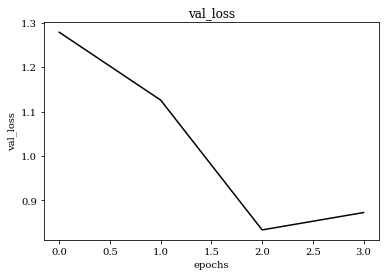

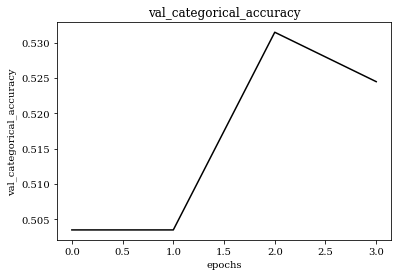

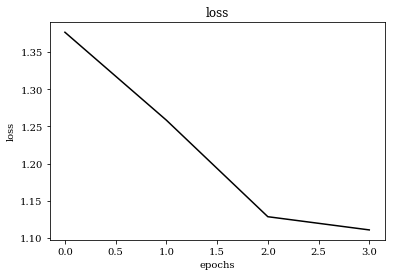

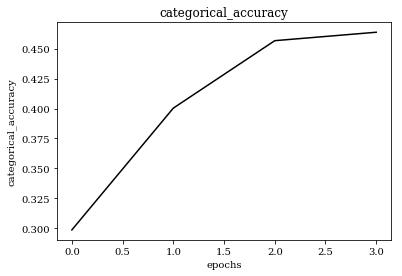

In [12]:
# 学習の進み具合を可視化
val_loss = prediction.hist.history['val_loss']
val_categorical_accuracy = prediction.hist.history['val_categorical_accuracy']
loss = prediction.hist.history['loss']
categorical_accuracy = prediction.hist.history['categorical_accuracy']

#
plt.rc('font', family='serif')

#
fig1 = plt.figure()
plt.title('val_loss')
plt.plot(prediction.hist.epoch, val_loss, label='acc', color='black')
plt.xlabel('epochs')
plt.ylabel('val_loss')

#
fig2 = plt.figure()
plt.title('val_categorical_accuracy')
plt.plot(prediction.hist.epoch, val_categorical_accuracy, label='acc', color='black')
plt.xlabel('epochs')
plt.ylabel('val_categorical_accuracy')

#
fig3 = plt.figure()
plt.title('loss')
plt.plot(prediction.hist.epoch, loss, label='acc', color='black')
plt.xlabel('epochs')
plt.ylabel('loss')

#
fig4 = plt.figure()
plt.title('categorical_accuracy')
plt.plot(prediction.hist.epoch, categorical_accuracy, label='acc', color='black')
plt.xlabel('epochs')
plt.ylabel('categorical_accuracy')